CNN for X-ray images

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [72]:
#Paths to the data used in the project
train_path = 'chest_xray/train'  #Train set
test_path = 'chest_xray/test'  #Test set
valid_path = 'chest_xray/val'  #Validation set

In [73]:
#Define Directories for train, test & Validation Set
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
valid_path = 'chest_xray/val'
#Define some often used standard parameters

#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

In [74]:
from keras.preprocessing.image import ImageDataGenerator


def preprocessing(batch_size):
    #Data augmentation used to artificially incraese the size of image training dataset. This will improve the models ability to predict new images

    #The image data generator for the training set
    image_gen = ImageDataGenerator(
        rescale=1. / 255,  #make the image contribute equally
        shear_range=0.2,  #streatces the image at a certain angle
        zoom_range=0.2,  #The image is enlarged
        horizontal_flip=True,  #Randomly flip some images horizontaly
    )

    #The image data generator for the test and validation sets
    test_data_gen = ImageDataGenerator(rescale=1. / 255)

    #Load the images with the use of DirectoryIterator from Tensorflow
    train = image_gen.flow_from_directory(
        train_path,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=batch_size
    )

    valid = test_data_gen.flow_from_directory(
        valid_path,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=batch_size
    )

    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train.classes),
        y=train.classes
    )

    test = test_data_gen.flow_from_directory(
        test_path,
        target_size=(img_height, img_width),
        color_mode='grayscale', shuffle=False,  #Shuffle here is false to prevent indexing complications
        class_mode='binary',
        batch_size=batch_size
    )

    return train, valid, weights, test


In [75]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(256, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=256))
cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 249, 249, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 123, 123, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 60, 60, 128)     

In [77]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [78]:
def run(batch_size, epochs, runs):
    current_run = 0

    train, valid, weights, test= preprocessing(batch_size)

    cw = dict(zip(np.unique(train.classes), weights))

    while current_run < runs:
        print("Run:",current_run)
        cnn.fit(train, epochs=epochs, validation_data=valid, class_weight=cw, callbacks=callbacks_list)
        pd.DataFrame(cnn.history.history).plot() #NEVER HAPPENS PLEASE TAKE A LOOK AT IT!
        current_run += 1

    test_accu = cnn.evaluate(test)
    print('The testing accuracy is :', test_accu[1] * 100, '%')

    preds = cnn.predict(test, verbose=1)
    predictions = preds.copy()
    predictions[predictions <= 0.5] = 0
    predictions[predictions > 0.5] = 1
    from sklearn.metrics import classification_report, confusion_matrix

    cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                      index=["Actual Normal", "Actual Pneumonia"],
                      columns=["Predicted Normal", "Predicted Pneumonia"])
    import seaborn as sns

    sns.heatmap(cm, annot=True, fmt="d")
    print(classification_report(y_true=test.classes, y_pred=predictions, target_names=['NORMAL', 'PNEUMONIA']))

    test.reset()
    x = np.concatenate([test.next()[0] for i in range(test.__len__())])
    y = np.concatenate([test.next()[1] for i in range(test.__len__())])
    print(x.shape)
    print(y.shape)
    #this little code above extracts the images from test Data iterator without shuffling the sequence
    # x contains image array and y has labels
    dic = {0: 'NORMAL', 1: 'PNEUMONIA'}
    plt.figure(figsize=(20, 20))
    for i in range(228, 9 + 228):
        if preds[i, 0] >= 0.5:
            out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
            plt.title(out + "\n Actual case : " + dic.get(y[i]))
            plt.imshow(np.squeeze(x[i]))
            plt.axis('off')
            plt.show()

        else:
            out = ('{:.2%} probability of being Normal case'.format(1 - preds[i][0]))
            plt.title(out + "\n Actual case : " + dic.get(y[i]))
            plt.imshow(np.squeeze(x[i]))
            plt.axis('off')
            plt.show()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Run: 0
39/39 [==============================] - 19s 491ms/step - loss: 0.2905 - accuracy: 0.8766
The testing accuracy is : 87.66025900840759 %
39/39 [==============================] - 18s 462ms/step
              precision    recall  f1-score   support

      NORMAL       0.83      0.85      0.84       234
   PNEUMONIA       0.91      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

(624, 500, 500, 1)
(624,)


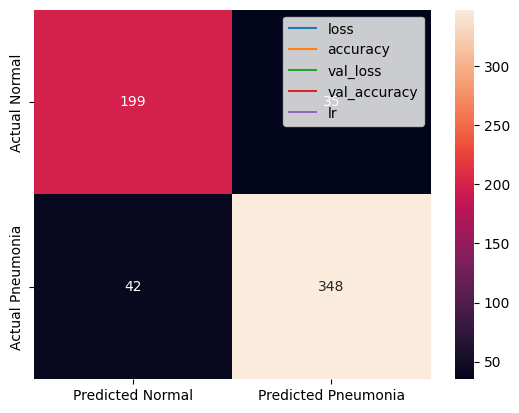

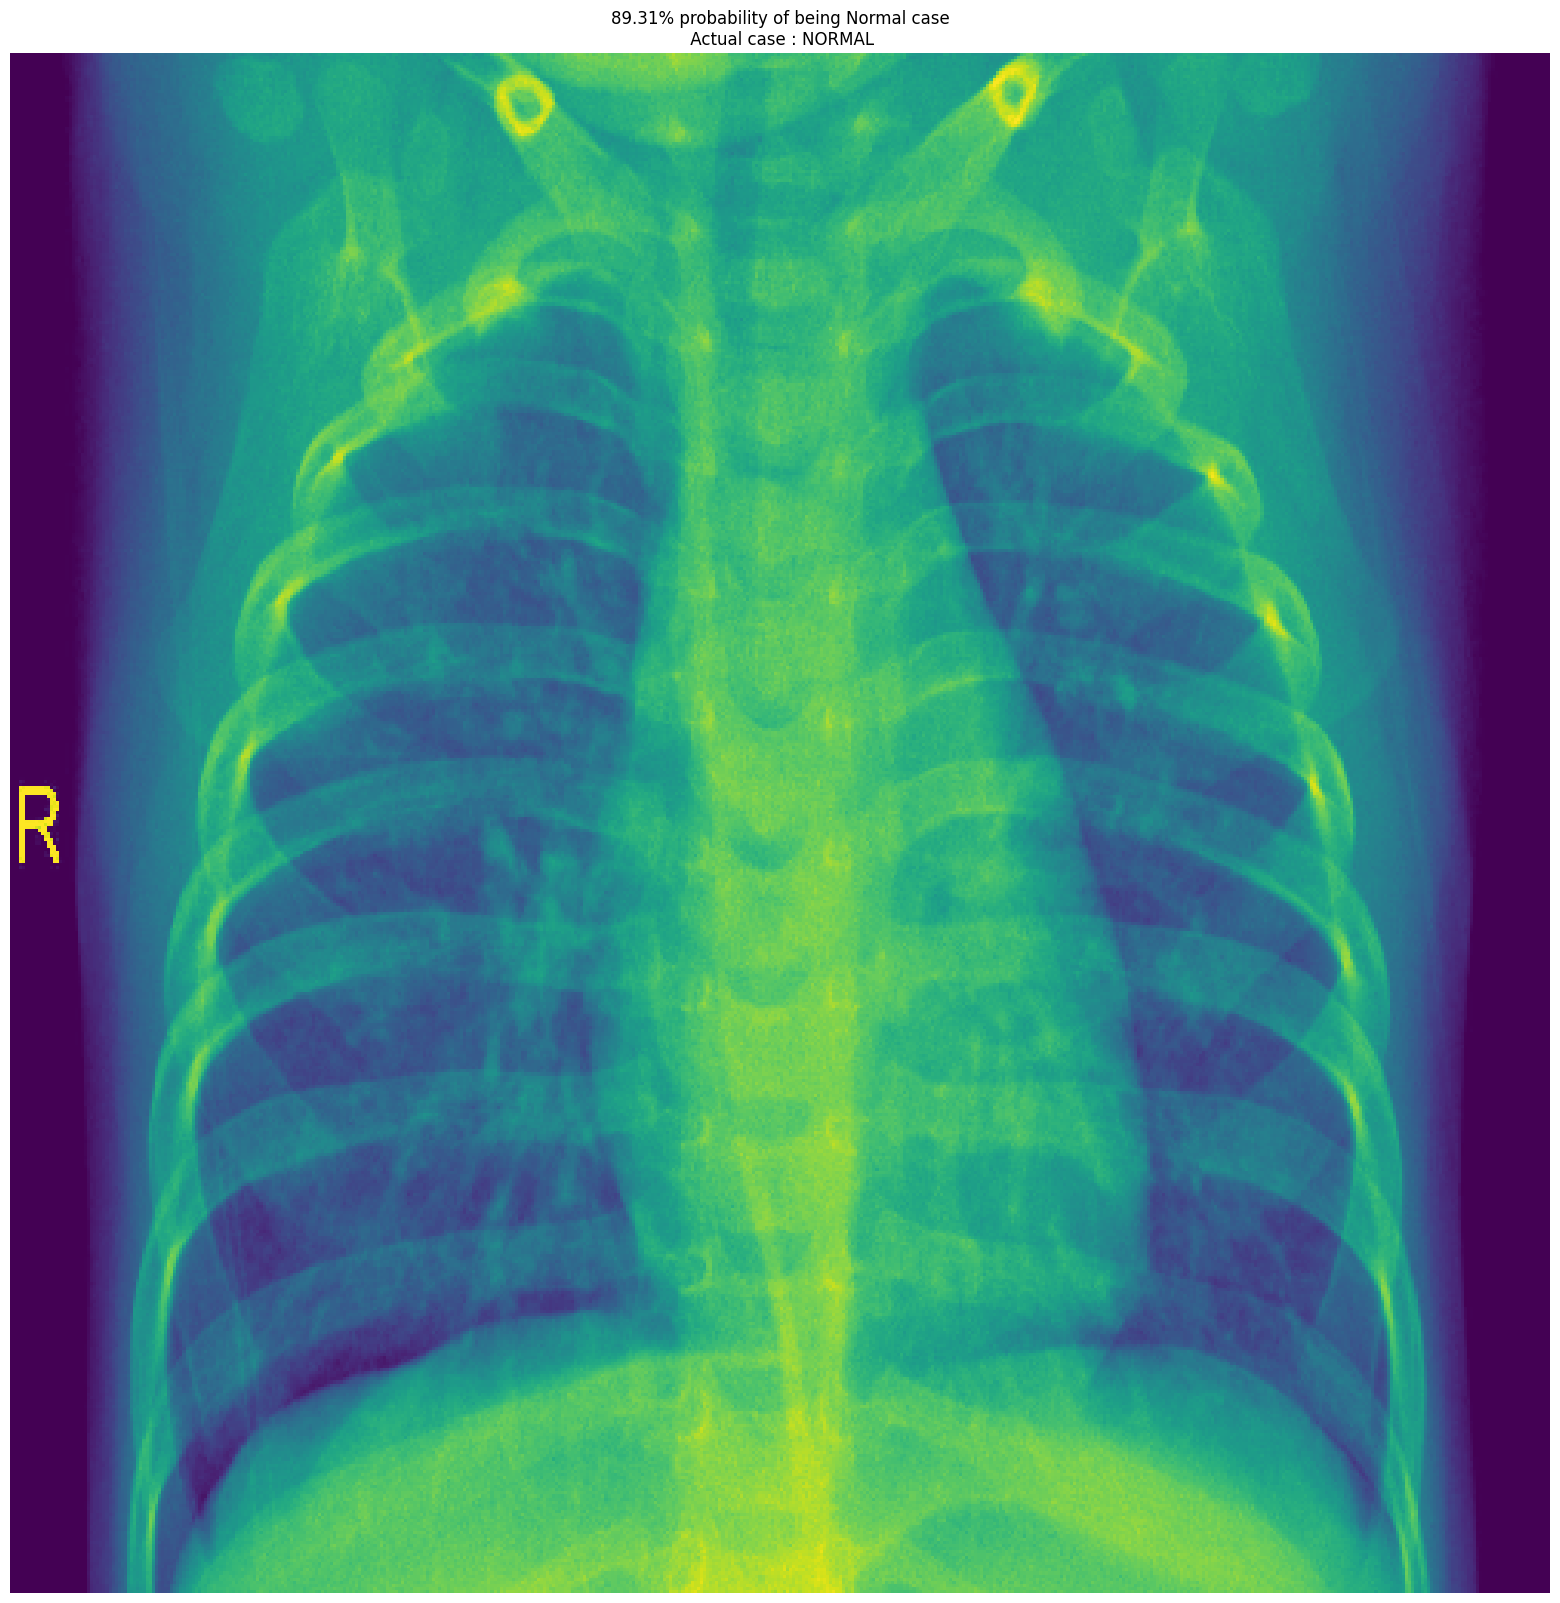

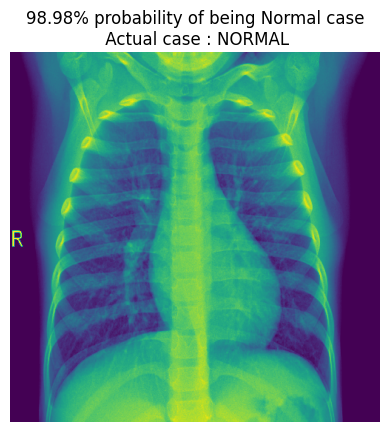

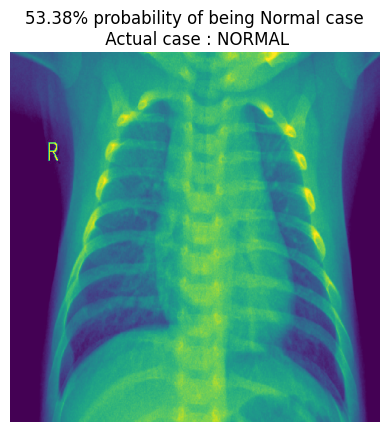

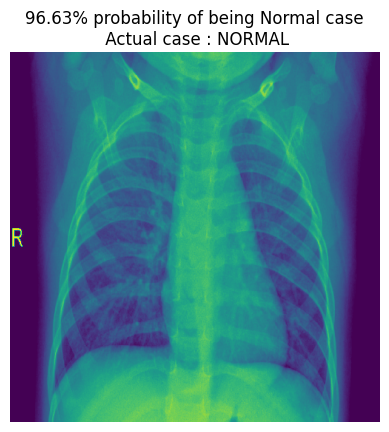

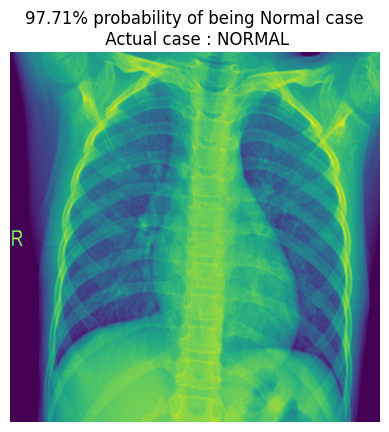

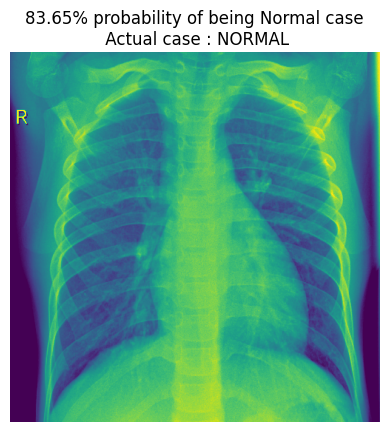

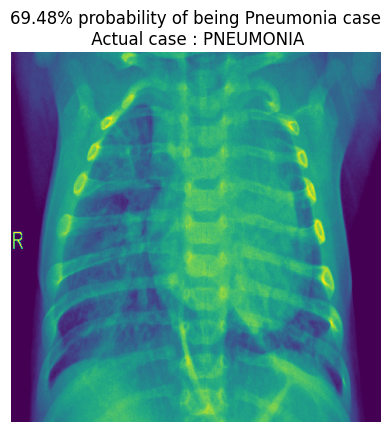

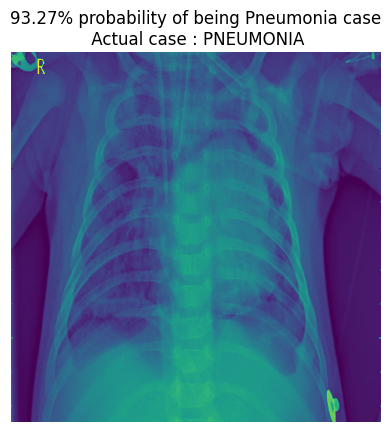

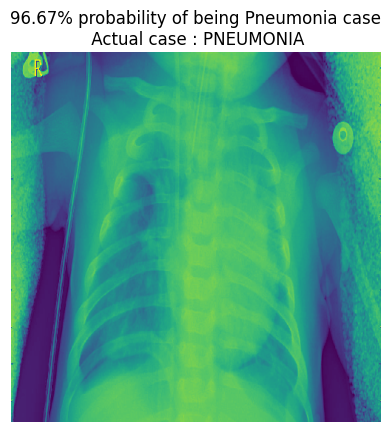

In [79]:
run(16, 1, 1) #Batch size = 16 , Epochs = 1, runs = 1